In [160]:
import re
import random
import pandas as pd
import hashlib

In [161]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [162]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'mean'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Functions Core Tools,88.684283,5.216723,14.662693,17
OAuth 2.0 RFC6749,91.888793,22.972198,24.724237,4
Node.js and Vite,963.625373,23.503058,39.457667,41
Django,973.341428,24.333536,38.475228,40
Azure Files Documentation,2168.754156,36.145903,124.093775,60
FSLogix,127.431441,42.477147,50.263538,3
Active Directory and Azure Files,1664.478859,44.985915,86.862470,37
CCH Tax Forms Project,951.071551,45.289121,111.255114,21
Python + Oauth2.0,1275.190711,55.443074,127.686511,23
Accounting,947.927199,55.760423,118.987916,17


# Histogram

sum of ages: ~50762.53


<Axes: >

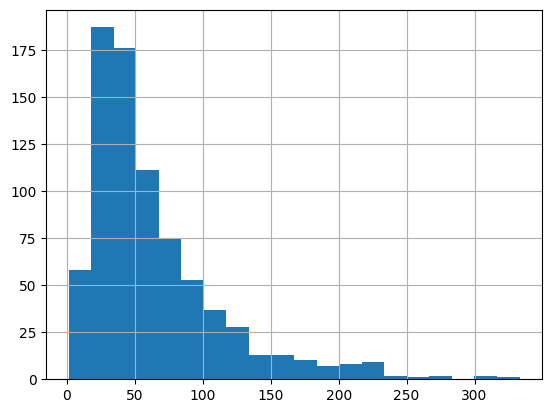

In [163]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~50762.53


<Axes: >

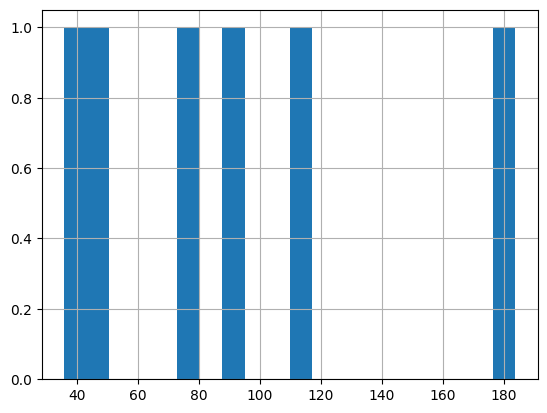

In [164]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [165]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [166]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [167]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [168]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [169]:
n = 5
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# existing_cards.sort_values(['age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 793
Total card age: 50762.53


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
41,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,333.119741,81.293366,-333.119741,1951.040773,0.441986,24,0,0,-333.119741
314,TSQL,Column and Table Aliasing:\n\nUse the AS keywo...,b2d566df6211f9f8dfb6e5a7760dec96,140.525385,81.293366,-333.119741,1951.040773,0.441986,24,1,0,-140.525385
581,TSQL,Subqueries:\n\nQueries nested within other que...,387d43697fcfe93769616f5775b954c0,110.318578,81.293366,-333.119741,1951.040773,0.441986,24,2,0,-110.318578
42,TSQL,"Q: Why would you use COALESCE(a, b) in a SELEC...",9599c71bb44aa9c23eca4cb094d34e63,106.344398,81.293366,-333.119741,1951.040773,0.441986,24,3,0,-106.344398
316,TSQL,Q: What does SUM(x) OVER (PARTITION BY y) do?\...,dda5b7601f3b5593f784810dd25436e7,105.560262,81.293366,-333.119741,1951.040773,0.441986,24,4,0,-105.560262
49,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,310.849623,79.734084,-310.849623,3906.970093,0.262847,49,0,0,-310.849623
322,Terraform Codebox,Terraform Registry is where official and commu...,5aeeebf71219ff35da683979c85ed7aa,228.716971,79.734084,-310.849623,3906.970093,0.262847,49,1,0,-228.716971
589,Terraform Codebox,A cloud-init.yaml.tpl file is a template for p...,e86be4b765ffee839b385a1a96ac3db1,219.531664,79.734084,-310.849623,3906.970093,0.262847,49,2,0,-219.531664
50,Terraform Codebox,Azure Files can be used to persist your coding...,9775a34a34e3610d8ddc43c1e0b44268,212.111547,79.734084,-310.849623,3906.970093,0.262847,49,3,0,-212.111547
323,Terraform Codebox,Out of Memory (OOM) condition\nOccurs when a V...,c531b35b8ce0b73612d57b26a4e8c0ff,169.788015,79.734084,-310.849623,3906.970093,0.262847,49,4,0,-169.788015


## Card Count

In [170]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [171]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [172]:
existing_cards.head(10)['age'].sum()

np.float64(1936.8661838113358)

In [173]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
41,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,333.119741,81.293366,-333.119741,1951.040773,0.441986,24,0,0,-333.119741
49,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,310.849623,79.734084,-310.849623,3906.970093,0.262847,49,0,0,-310.849623
29,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,303.403823,89.581078,-303.403823,3224.918798,0.447414,36,0,0,-303.403823
130,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,276.050070,69.623693,-276.050070,4943.282237,0.005190,71,0,0,-276.050070
102,Power BI,"Q: In a Pro workspace, which Service-side feat...",25b487580bae6b89adcd0c6909e8aa20,268.496736,73.896567,-268.496736,2438.586721,0.197199,33,0,0,-268.496736
267,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,265.417859,94.805051,-265.417859,1896.101012,0.443107,20,0,0,-265.417859
113,JavaScript Concepts,Reserved Words: Identifiers cannot be the same...,042a95e59a28c2e0d94382aacc1a1751,236.280710,72.467412,-236.280710,3695.838021,0.121071,51,0,0,-236.280710
82,CCH Axcess,Client IDs can have up to 15 characters and ca...,220856831fa9fb7a8c1022a5ce48fb6d,235.137829,77.905807,-235.137829,4596.442593,0.665665,59,0,0,-235.137829
9,Azure VM + Developer,Port Forwarding\nAn SSH feature that lets you ...,ab24eca09d42d7293e8d28293893ab14,231.019449,93.893781,-231.019449,2159.556966,0.786148,23,0,0,-231.019449
322,Terraform Codebox,Terraform Registry is where official and commu...,5aeeebf71219ff35da683979c85ed7aa,228.716971,79.734084,-310.849623,3906.970093,0.262847,49,1,0,-228.716971


In [174]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 64.013'